In [3]:
import json
import os
import numpy as np
import pandas as pd
import ruptures as rpt
import time
from tqdm import tqdm

import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook
import seaborn as sns

from nas_environment import Environment

In [5]:
precomputed_logs_path = "C:/Users/makov/OneDrive/Desktop/nas-bench-nlp-release/train_logs_single_run"
env = Environment(precomputed_logs_path)
len(env._logs)

search_set = env.get_precomputed_recepies()
len(search_set)

14322

In [7]:
train_epochs = 10
rounds = 5
iters_per_round = 100
env.simulated_train(search_set[1], train_epochs)

In [ ]:
with open("results_cusum_and_peaks.json", "r") as f:
    res = json.load(f)

In [23]:
def test(res, thr, type_ = "first_change_point") :  
    all_test_losses = []
    all_wall_times = []
    N = iters_per_round
    saved_epoches = 0
    for i in tqdm(range(rounds)):
        seed = int(time.time() * 1e7 + i) // (2**32)
        env.reset()
        np.random.seed(seed)

        R = 50 
        eta = 3
        s_max = int(np.floor(np.log(R)/np.log(eta)))
        print("smax", s_max)
        # B = (s_max + 1)*R
        B = N*R/3.5

        test_losses = []
        wall_times = []

        log_cnt = 0
        for s in range(s_max, -1, -1):
            n = int(np.ceil(float(B)/R * float(eta)**s/(s + 1)))
            r = R*float(eta)**(-s)
            T = np.random.choice(len(search_set), n+50, replace=False) # берем с запасом
            sum_r = 0
            for i in range(s + 1):
                n_i = int(np.floor(n*float(eta)**(-i)))
                r_i = int(np.floor(r*eta**i))
                sum_r += r_i
                L = []
                for t in T[:n]:
                    try:
                        early_stopping_epoch = int(res[str(t)][thr][type_])
                    except Exception as ex:
                         early_stopping_epoch = 51
                    ep = np.min([r_i, early_stopping_epoch])
                    saved_epoches += r_i - ep # cмотрим сколько эпох сохранили из-за ранней остановки
                    env.simulated_train(search_set[t], ep)
                    if env.get_model_status(search_set[t]) == 'OK':
                        L.append(env.get_model_stats(search_set[t], ep - 1)['val_loss'])
                    else:
                        L.append(np.inf)
                    log_cnt += 1
                    if log_cnt % 25 == 0:
                        test_losses.append(env.get_test_loss_of_the_best_validated_architecture())
                        wall_times.append(env.get_total_time())
                k = n
                
                while saved_epoches > r_i: # если общее число сохраненныйх эпох Больше чем r_i
                    #лобучаем еще модели
                    t = T[k]
                    try:
                        early_stopping_epoch = int(res[str(t)][thr][type_])
                    except Exception as ex:
                        early_stopping_epoch = 51
                    ep = np.min([r_i, early_stopping_epoch])
                    env.simulated_train(search_set[t], ep)
                    if env.get_model_status(search_set[t]) == 'OK':
                        L.append(env.get_model_stats(search_set[t], ep - 1)['val_loss'])
                    else:
                        L.append(np.inf)
                    log_cnt += 1
                    if log_cnt % 25 == 0:
                        test_losses.append(env.get_test_loss_of_the_best_validated_architecture())
                        wall_times.append(env.get_total_time())

                    saved_epoches -= ep 
                    k+=1
                    
                test_losses.append(env.get_test_loss_of_the_best_validated_architecture())
                wall_times.append(env.get_total_time())

                L = np.array(L)
                halved_inds = np.argsort(L)[:int(np.floor(n_i/float(eta))) + 50] #опять оставляем запас
                halved_inds = halved_inds[L[halved_inds] < np.inf]
                T = T[halved_inds]
            print("sum_r:", sum_r, "r:", r)
        all_test_losses.append(test_losses)
        all_wall_times.append(wall_times)
        print(s)
    return all_test_losses, all_wall_times

In [24]:
for cusum_threshold in [0.005]:
    all_test_losses, all_wall_times = test(res, str(cusum_threshold), "first_change_point")
    alg_resutls["first_change_point"][str(cusum_threshold)] = {'all_test_losses':all_test_losses, 'all_wall_times':all_wall_times}


  0%|          | 0/5 [00:00<?, ?it/s]

smax 3
sum_r: 71 r: 1.8518518518518516
sum_r: 71 r: 5.555555555555555


 20%|██        | 1/5 [00:01<00:04,  1.02s/it]

sum_r: 65 r: 16.666666666666664
sum_r: 50 r: 50.0
0
smax 3
sum_r: 71 r: 1.8518518518518516


 40%|████      | 2/5 [00:01<00:02,  1.05it/s]

sum_r: 71 r: 5.555555555555555
sum_r: 65 r: 16.666666666666664
sum_r: 50 r: 50.0
0
smax 3
sum_r: 71 r: 1.8518518518518516


 60%|██████    | 3/5 [00:03<00:02,  1.16s/it]

sum_r: 71 r: 5.555555555555555
sum_r: 65 r: 16.666666666666664
sum_r: 50 r: 50.0
0
smax 3
sum_r: 71 r: 1.8518518518518516


 80%|████████  | 4/5 [00:04<00:01,  1.14s/it]

sum_r: 71 r: 5.555555555555555
sum_r: 65 r: 16.666666666666664
sum_r: 50 r: 50.0
0
smax 3
sum_r: 71 r: 1.8518518518518516


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]

sum_r: 71 r: 5.555555555555555
sum_r: 65 r: 16.666666666666664
sum_r: 50 r: 50.0
0


In [8]:
alg_resutls = {}
alg_resutls["first_change_point"] = {}

for cusum_threshold in tqdm(np.exp(np.linspace(-6, 3, 100))):
    all_test_losses, all_wall_times = test(res, str(cusum_threshold), "first_change_point")
    alg_resutls["first_change_point"][str(cusum_threshold)] = {'all_test_losses':all_test_losses, 'all_wall_times':all_wall_times}


100%|██████████| 100/100 [04:49<00:00,  2.89s/it]


In [25]:
result = {}
for threashold in alg_resutls["first_change_point"]:
    result[f"first_change_point_{threashold}"] =  {'all_wall_times': alg_resutls["first_change_point"][threashold]['all_wall_times'],
                                      'all_test_losses': alg_resutls["first_change_point"][threashold]['all_test_losses']}

c:\Users\Maria\Desktop\Maria\Maria\from github\Project_reseach\nas_environment.py:36: RuntimeWarning: All-NaN axis encountered
  cur_loss = np.nanmin(log['test_losses'])


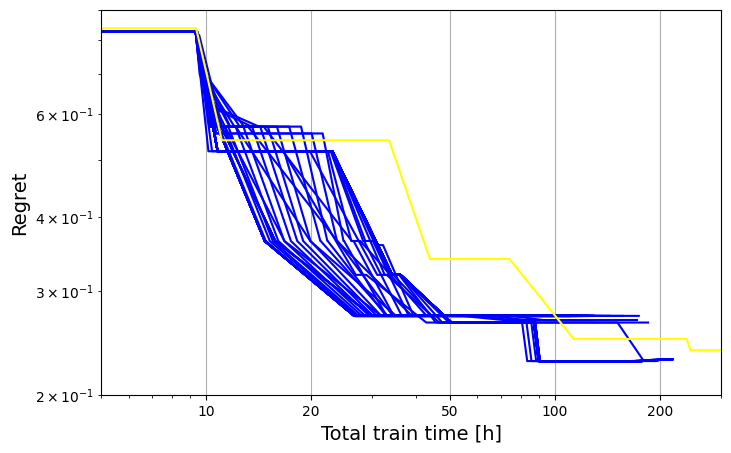

In [26]:
y_opt = env.get_best_possible_test_loss()

plt.figure(figsize=(8, 5), dpi=100)


for i, alg_name in enumerate(list(result.keys())):
    
    all_test_losses = result[alg_name]['all_test_losses']
    all_wall_times = result[alg_name]['all_wall_times']

    all_xs = np.array(all_test_losses)
    all_ts = np.array(all_wall_times)/3600.

    s = 1.96/np.sqrt(all_xs.shape[0])

    all_ts_mean = all_ts.mean(axis=0)

    all_ts_max = all_ts_mean + s*all_ts.std(axis=0)
    all_ts_min = all_ts_mean - s*all_ts.std(axis=0)

    all_xs_mean = np.nanmean(all_xs, axis=0)

    all_xs_max = all_xs_mean + s*np.nanstd(all_xs, axis=0)
    all_xs_min = all_xs_mean - s*np.nanstd(all_xs, axis=0)
    
    if alg_name[:5] == "cusum":
        c = "green"
    elif alg_name[:4] == "peak":
        c = "orange"
    else:
        if alg_name[-5:] == "0.005":
            c = "yellow"
        else: c = "blue"
        
    plt.plot(all_ts_mean, all_xs_mean - y_opt, lw=1.5, color=c, label=alg_name) #color = f'C{i}'
    plt.fill_between(all_ts_mean, all_xs_min - y_opt, all_xs_max - y_opt, alpha=0.1, edgecolor=c)

#plt.legend()
plt.xlabel('Total train time [h]', fontsize=14)
plt.ylabel('Regret', fontsize=14)
plt.ylim([0.2, 0.9])
plt.xscale('log')
plt.yscale('log')
plt.xlim([5, 300])
plt.xticks([10, 20, 50, 100, 200]);
plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.grid()
# plt.savefig('cusum_experiments_pareto.png', dpi=300, bbox_inches='tight')

# Statistics

In [92]:
with open("results_cusum_and_peaks.json", "r") as f:
    res = json.load(f)

In [121]:
statistics = {}
for t in tqdm(np.exp(np.linspace(-6, 3, 100))):
    trains = []
    vals = []
    tests = []
    times = []
    epoches = []
    for key in res.keys():
        #'train_loss','val_loss','test_loss','wall_time','cur_epoch','status'
        env.reset()
        try:
            env.simulated_train(search_set[int(key)], 50)
        except Exception as ex:
            pass#print(ex)
        try:
            ep = int(res[key][str(t)]["first_change_point"])
            #print(ep)
            model_results = env.get_model_stats(search_set[int(key)], (ep if ep != 50 else 49))
            if model_results["status"] == "OK":
                trains.append(model_results["train_loss"])
                vals.append(model_results["val_loss"])
                tests.append(model_results["test_loss"])
                times.append(model_results["wall_time"])
                epoches.append(ep)
        except Exception as ex:
            pass#print(ex)
    statistics[t] = {'mean_train_loss': np.mean(trains),
                'mean_val_loss': np.mean(vals),
                'mean_test_loss': np.mean(tests),
                'mean_wall_time': np.mean(times),
                'mean_epoch': np.mean(epoches),
                'min_train_loss':np.nan  if len(trains) == 0 else np.min(trains),
                'min_val_loss':  np.nan if len(vals) == 0 else np.min(vals),
                'min_test_loss': np.nan if len(tests) == 0 else np.min(tests)}
        

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Maria\Documents\.39venv\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Maria\Documents\.39venv\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [18:45<00:00, 11.25s/it]


In [122]:
trains = []
vals = []
tests = []
times = []
epoches = []
for key in res.keys():
    #'train_loss','val_loss','test_loss','wall_time','cur_epoch','status'
    env.reset()
    try:
        env.simulated_train(search_set[int(key)], 50)
    except Exception as ex:
        pass
    try:
        model_results = env.get_model_stats(search_set[int(key)], 49)
        if model_results["status"] == "OK":
            trains.append(model_results["train_loss"])
            vals.append(model_results["val_loss"])
            tests.append(model_results["test_loss"])
            times.append(model_results["wall_time"])
            epoches.append(ep)
    except Exception as ex:
        pass
statistics['full'] = {'mean_train_loss': np.mean(trains),
            'mean_val_loss': np.mean(vals),
            'mean_test_loss': np.mean(tests),
            'mean_wall_time': np.mean(times),
            'mean_epoch': np.mean(epoches),
            'min_train_loss': np.min(trains),
            'min_val_loss': np.min(vals),
            'min_test_loss': np.min(tests)}
    

In [123]:
df = pd.DataFrame(statistics).dropna(axis = 1)
df

,0.004276820349208926,0.004683842946287709,0.005129601655946807,0.005617782972323415,0.006152424231136861,0.006737946999085467,0.007379193640893606,0.008081467366424134,0.008850576089052096,0.009692880458015281,...,9.705835210448603,10.629534110942782,11.641140918409853,12.74902177911694,13.962339040785407,15.291127026637097,16.746375020814504,18.340118151476506,20.085536923187668,full
mean_train_loss,5.651420,5.622790,5.613686,5.609462,5.609239,5.609190,5.609066,5.609580,5.609658,5.609931,...,4.730395,4.730274,4.730326,4.730291,4.729353,4.729010,4.731182,4.728467,4.728375,4.736984
mean_val_loss,5.709301,5.682241,5.673628,5.669662,5.669384,5.669319,5.669142,5.669575,5.669651,5.669880,...,5.169839,5.169737,5.169786,5.169824,5.168897,5.168550,5.170672,5.168005,5.167913,5.165658
mean_test_loss,5.659843,5.633353,5.624887,5.621125,5.620943,5.620941,5.620787,5.621229,5.621347,5.621576,...,5.118387,5.118266,5.118316,5.118298,5.117375,5.117028,5.119143,5.116490,5.116400,5.111740
mean_wall_time,220.741570,225.916751,224.515699,226.569542,230.752715,233.175916,234.585032,236.826087,238.645572,242.130425,...,9553.067170,9553.231424,9553.693991,9553.795727,9553.833179,9553.883494,9552.974365,9554.161980,9554.318395,9552.326779
mean_epoch,1.083133,1.090445,1.091233,1.109178,1.124151,1.139188,1.146619,1.155915,1.160067,1.176744,...,49.967118,49.968305,49.972697,49.973291,49.973647,49.974122,49.968902,49.976733,49.977564,50.000000
min_train_loss,5.087873,5.087873,5.073929,5.073929,5.073929,5.073929,5.073929,5.073929,5.073929,5.073929,...,3.060182,3.060182,3.060182,3.060182,3.060182,3.060182,3.060182,3.060182,3.060182,3.060182
min_val_loss,5.196837,5.196837,5.184992,5.184992,5.184992,5.184992,5.184992,5.184992,5.184992,5.184992,...,4.415310,4.415310,4.415310,4.415310,4.415310,4.415310,4.415310,4.415310,4.415310,4.415310
min_test_loss,5.161230,5.161230,5.143626,5.143626,5.143626,5.143626,5.143626,5.143626,5.143626,5.143626,...,4.368057,4.368057,4.368057,4.368057,4.368057,4.368057,4.368057,4.368057,4.368057,4.368057


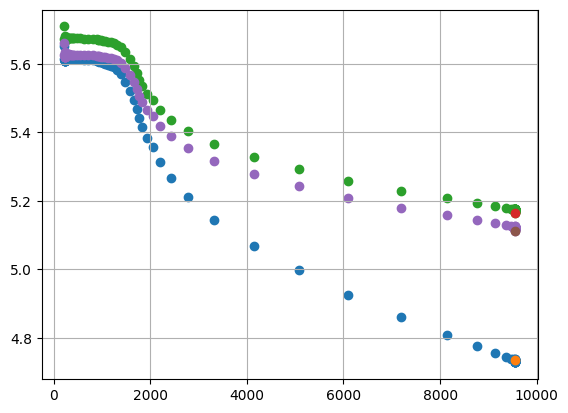

In [139]:

plt.scatter(df.loc["mean_wall_time"], df.loc["mean_train_loss"])
plt.scatter(df.loc["mean_wall_time", "full"], df.loc["mean_train_loss", "full"])

plt.scatter(df.loc["mean_wall_time"], df.loc["mean_val_loss"])
plt.scatter(df.loc["mean_wall_time", "full"], df.loc["mean_val_loss", "full"])

plt.scatter(df.loc["mean_wall_time"], df.loc["mean_test_loss"])
plt.scatter(df.loc["mean_wall_time", "full"], df.loc["mean_test_loss", "full"])

plt.grid()
plt.show()


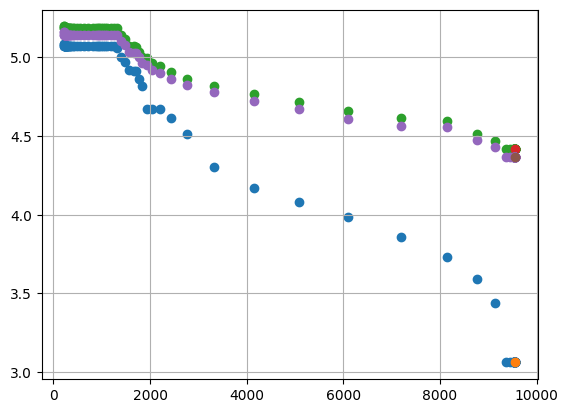

In [140]:

plt.scatter(df.loc["mean_wall_time"], df.loc["min_train_loss"])
plt.scatter(df.loc["mean_wall_time", "full"], df.loc["min_train_loss", "full"])

plt.scatter(df.loc["mean_wall_time"], df.loc["min_val_loss"])
plt.scatter(df.loc["mean_wall_time", "full"], df.loc["min_val_loss", "full"])

plt.scatter(df.loc["mean_wall_time"], df.loc["min_test_loss"])
plt.scatter(df.loc["mean_wall_time", "full"], df.loc["min_test_loss", "full"])

plt.grid()
plt.show()


# Classification

In [1]:
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix

In [8]:
models = []
val_losses = []
best_val_losses = []

for i in range(len(search_set)):
        #'train_loss','val_loss','test_loss','wall_time','cur_epoch','status'
        env.reset()
        try:
            env.simulated_train(search_set[int(i)], 50)
        except Exception as ex:
            print(1, ex)
            pass#print(ex)

        try:
            model_val_losses = []
            for j in range(50):
                model_results = env.get_model_stats(search_set[int(i)], j)
                if env.get_model_stats(search_set[int(i)], j)["status"] == "OK":
                    model_val_losses.append(env.get_model_stats(search_set[int(i)], j)["val_loss"])
                else: break
            models.append(i)
            if len(model_val_losses) < 50: 
                model_val_losses = model_val_losses + [np.inf for i in range(50 - len(model_val_losses))]
            val_losses.append(model_val_losses)
            best_val_losses.append(np.min(model_val_losses))
        except Exception as ex:
            print(2, i, j, ex)
            pass#print(ex)

2 11 0 Required epoch exceeds current training epochs.
2 572 0 Required epoch exceeds current training epochs.
2 591 0 Required epoch exceeds current training epochs.
2 1614 0 Required epoch exceeds current training epochs.
2 2618 0 Required epoch exceeds current training epochs.
2 2624 0 Required epoch exceeds current training epochs.
2 2640 0 Required epoch exceeds current training epochs.
2 2693 0 Required epoch exceeds current training epochs.
2 2937 0 Required epoch exceeds current training epochs.
2 3199 0 Required epoch exceeds current training epochs.
2 3323 0 Required epoch exceeds current training epochs.
2 3332 0 Required epoch exceeds current training epochs.
2 3609 0 Required epoch exceeds current training epochs.
2 3795 0 Required epoch exceeds current training epochs.
2 4031 0 Required epoch exceeds current training epochs.
2 4080 0 Required epoch exceeds current training epochs.
2 4211 0 Required epoch exceeds current training epochs.
2 4368 0 Required epoch exceeds cur

In [9]:
len(best_val_losses)

14257

In [10]:
val_losses = np.array(val_losses)
best_val_losses = np.array(best_val_losses)
models = np.array(models)

val_losses.shape, best_val_losses.shape, models.shape

((14257, 50), (14257,), (14257,))

In [11]:
indexes = np.argsort(best_val_losses)[:int(len(best_val_losses) * 0.05)]
assert np.min(best_val_losses) == np.min(best_val_losses[indexes])
best_models = models[indexes]

In [44]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

def make_datasets(window_size):
    X = np.expand_dims(val_losses[:, window_size], axis = 1) # val_losses[:, :window_size] 
    Y = np.array([1 if i in indexes else 0 for i in range(len(X))])
    X_train,  X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = 42)
    X_train[X_train == np.inf] = 1000
    X_test[X_test == np.inf] = 1000

    balancer = RandomUnderSampler()
    balanced_train_x, balanced_train_y = balancer.fit_resample(X_train, Y_train)
    return balanced_train_x,  X_test, balanced_train_y, Y_test


In [45]:
def classification(window_size, type = "MLP"):
    print("")
    X_train, X_test, Y_train, Y_test = make_datasets(window_size)
    if type == "MLP":
        clf = MLPClassifier(max_iter = 1000, random_state = 42).fit(X_train, Y_train)
    elif type == "Forest":
        clf = RandomForestClassifier(random_state = 42).fit(X_train, Y_train)
    elif type == "Gauss":
        clf = GaussianProcessClassifier(random_state = 42).fit(X_train, Y_train)
    elif type == "Neighbors":
        clf = KNeighborsClassifier().fit(X_train, Y_train)
    elif type == "Ada":
        clf = AdaBoostClassifier(random_state = 42).fit(X_train, Y_train)
    elif type == "xgboost":
        clf = XGBClassifier(n_jobs=-1).fit(X_train, Y_train)
        
    print("Type:", type)
    print("Window size:", window_size)
    print("Train accuracy:", clf.score(X_train, Y_train))
    print("Test accuracy:", clf.score(X_test, Y_test))
    print("Train confusion matrix:")
    print(confusion_matrix(Y_train, clf.predict(X_train)))
    print("Test confusion matrix:")
    print(confusion_matrix(Y_test, clf.predict(X_test)))
    return clf.score(X_test, Y_test)

In [46]:
test_accs = []
nums = [5, 10, 15, 20, 25, 30, 35, 40]
for n in nums:
    test_acc = classification(n, "xgboost")
    test_accs.append(test_acc)


Type: xgboost
Window size: 5
Train accuracy: 0.9423758865248227
Test accuracy: 0.9014726507713885
Train confusion matrix:
[[526  38]
 [ 27 537]]
Test confusion matrix:
[[2436  268]
 [  13  135]]

Type: xgboost
Window size: 10
Train accuracy: 0.9725177304964538
Test accuracy: 0.9460028050490884
Train confusion matrix:
[[550  14]
 [ 17 547]]
Test confusion matrix:
[[2560  144]
 [  10  138]]

Type: xgboost
Window size: 15
Train accuracy: 0.9893617021276596
Test accuracy: 0.958625525946704
Train confusion matrix:
[[558   6]
 [  6 558]]
Test confusion matrix:
[[2590  114]
 [   4  144]]

Type: xgboost
Window size: 20
Train accuracy: 0.9955673758865248
Test accuracy: 0.9712482468443198
Train confusion matrix:
[[563   1]
 [  4 560]]
Test confusion matrix:
[[2628   76]
 [   6  142]]

Type: xgboost
Window size: 25
Train accuracy: 0.9973404255319149
Test accuracy: 0.9737026647966339
Train confusion matrix:
[[562   2]
 [  1 563]]
Test confusion matrix:
[[2630   74]
 [   1  147]]

Type: xgboost
Wi

In [47]:
test_accs

[0.9014726507713885,
 0.9460028050490884,
 0.958625525946704,
 0.9712482468443198,
 0.9737026647966339,
 0.9803646563814866,
 0.9800140252454418,
 0.988078541374474]

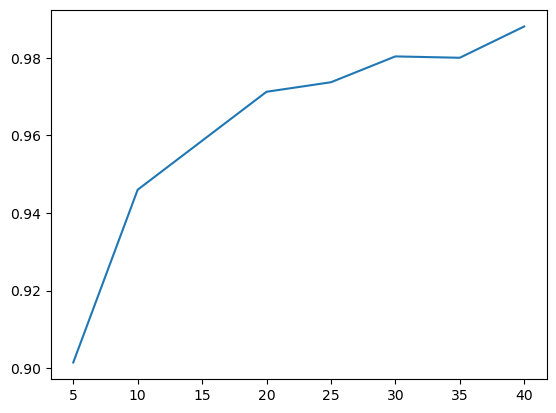

In [48]:
plt.plot(nums,test_accs)

# With embedings

In [49]:

df_recepie_vectors = pd.read_csv('data/embeddings/doc2vec_features_lowdim.csv').set_index('recepie_id')
df_recepie_vectors.min(),df_recepie_vectors.max()

(v00   -11.595691
 v01    -7.844798
 v02    -9.961797
 v03    -7.561448
 v04    -5.888516
 v05    -9.258999
 v06    -6.432005
 v07    -6.595271
 v08    -3.686212
 v09    -7.829308
 dtype: float64,
 v00    6.682056
 v01    6.079530
 v02    5.514811
 v03    7.006998
 v04    8.246789
 v05    7.737588
 v06    8.245940
 v07    4.879920
 v08    3.454343
 v09    8.640629
 dtype: float64)

In [114]:
np.isnan(env._logs[i]["val_losses"][0])

True

In [112]:
env._logs[i]["val_losses"][0] == float('nan')

False

In [116]:
def make_datasets(window_size):
    X = []
    best_val_losses = []
    for i in tqdm(range(len(search_set))):
        recepie_id = env._logs[i]["recepie_id"]
        log = env._logs[i]["val_losses"]
        if len(log) > window_size:
            if np.isnan(np.min(log)):
                continue
            log_ = np.array([log[window_size]]) #log[:window_size] #
            emb = df_recepie_vectors.loc[recepie_id].values
            x = np.concatenate((log_, emb)).reshape(-1)
            X.append(x)
            best_val_losses.append(np.min(log))
    X = np.stack(X)
    best_val_losses = np.array(best_val_losses)
    indexes = np.argsort(best_val_losses)[:int(len(best_val_losses) * 0.05)]
    assert np.min(best_val_losses[indexes]) == np.min(best_val_losses)
    Y = np.array([1 if i in indexes else 0 for i in range(len(X))])

    X_train,  X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.8, shuffle = True, random_state = 42)
    X_train[X_train == np.inf] = 1000
    X_test[X_test == np.inf] = 1000

    balancer = RandomOverSampler()
    balanced_train_x, balanced_train_y = balancer.fit_resample(X_train, Y_train)
    return balanced_train_x,  X_test, balanced_train_y, Y_test
        

In [118]:
test_accs = []
window_sizes = [5, 10, 15, 20, 25, 30, 35, 40]
for window_size in window_sizes:
    test_acc = classification(n, "xgboost")
    test_accs.append(test_acc)

100%|██████████| 14322/14322 [00:00<00:00, 27089.98it/s]


Type: xgboost
Window size: 40
Train accuracy: 1.0
Test accuracy: 0.9918103448275862
Train confusion matrix:
[[2208    0]
 [   0 2208]]
Test confusion matrix:
[[8759   53]
 [  23  445]]



100%|██████████| 14322/14322 [00:00<00:00, 28813.34it/s]


Type: xgboost
Window size: 40
Train accuracy: 1.0
Test accuracy: 0.9915948275862069
Train confusion matrix:
[[2208    0]
 [   0 2208]]
Test confusion matrix:
[[8758   54]
 [  24  444]]



100%|██████████| 14322/14322 [00:00<00:00, 22912.52it/s]


Type: xgboost
Window size: 40
Train accuracy: 1.0
Test accuracy: 0.9915948275862069
Train confusion matrix:
[[2208    0]
 [   0 2208]]
Test confusion matrix:
[[8757   55]
 [  23  445]]



100%|██████████| 14322/14322 [00:00<00:00, 29592.27it/s]


Type: xgboost
Window size: 40
Train accuracy: 1.0
Test accuracy: 0.9914870689655172
Train confusion matrix:
[[2208    0]
 [   0 2208]]
Test confusion matrix:
[[8756   56]
 [  23  445]]



100%|██████████| 14322/14322 [00:00<00:00, 27855.12it/s]


Type: xgboost
Window size: 40
Train accuracy: 1.0
Test accuracy: 0.9918103448275862
Train confusion matrix:
[[2208    0]
 [   0 2208]]
Test confusion matrix:
[[8757   55]
 [  21  447]]



100%|██████████| 14322/14322 [00:00<00:00, 29761.44it/s]


Type: xgboost
Window size: 40
Train accuracy: 1.0
Test accuracy: 0.9917025862068966
Train confusion matrix:
[[2208    0]
 [   0 2208]]
Test confusion matrix:
[[8759   53]
 [  24  444]]



100%|██████████| 14322/14322 [00:00<00:00, 27548.56it/s]


Type: xgboost
Window size: 40
Train accuracy: 1.0
Test accuracy: 0.9914870689655172
Train confusion matrix:
[[2208    0]
 [   0 2208]]
Test confusion matrix:
[[8758   54]
 [  25  443]]



100%|██████████| 14322/14322 [00:00<00:00, 28885.92it/s]


Type: xgboost
Window size: 40
Train accuracy: 1.0
Test accuracy: 0.9918103448275862
Train confusion matrix:
[[2208    0]
 [   0 2208]]
Test confusion matrix:
[[8759   53]
 [  23  445]]


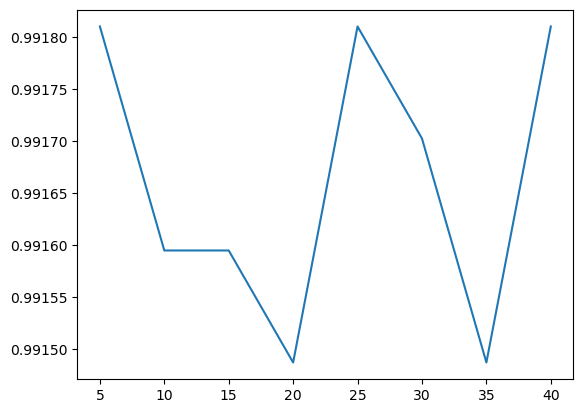

In [119]:
plt.plot(window_sizes, test_accs)

## with cusum scores

In [120]:
def cusum_detector(series, threshold):
    normal_to_change_stat, change_to_normal_stat  = np.zeros(len(series)), np.zeros(len(series))
    normal_to_change_ind, change_to_normal_ind  = [], []
    all_change_idxs = []
    change_mask = np.zeros(len(series))
    curr_start = -1 #добавила, тк вылетала ошибка (см. ниже)
    for i in range(1, len(series)):
        t = series[i] - series[i-1]
        normal_to_change_stat[i] = max(0, normal_to_change_stat[i - 1] + t) # 0 -> delta?
        change_to_normal_stat[i] = max(0, change_to_normal_stat[i - 1] - t)
        
        if normal_to_change_stat[i] > threshold:
            curr_start = i
            normal_to_change_ind.append(i)
            normal_to_change_stat[i] = 0
            all_change_idxs.append(i)
        if change_to_normal_stat[i] > threshold:
            change_to_normal_ind.append(i)
            change_to_normal_stat[i] = 0
            change_mask[curr_start: i + 1] = True # ошибка : curr_start использована до определения
            all_change_idxs.append(i)
            
    all_change_idxs.append(len(series))
    return change_mask, all_change_idxs, normal_to_change_stat, change_to_normal_stat

In [135]:
thresholds = np.exp(np.linspace(-6, 3, 10))
cusum_scores = []
for val_loss in tqdm(val_losses):
    tmp1 = []
    tmp2 = []
    for thr in thresholds:
        change_mask, all_change_idxs, normal_to_change_stat, change_to_normal_stat = cusum_detector(val_loss, thr)
        tmp1.append(normal_to_change_stat)
        tmp2.append(change_to_normal_stat)
    cusum_scores.append([tmp1, tmp2])

  0%|          | 0/14257 [00:00<?, ?it/s]C:\Users\makov\AppData\Local\Temp\ipykernel_30124\3180448035.py:8: RuntimeWarning: invalid value encountered in double_scalars
  t = series[i] - series[i-1]
100%|██████████| 14257/14257 [00:06<00:00, 2133.21it/s]


In [136]:
cusum_scores = np.array(cusum_scores)
cusum_scores = cusum_scores.reshape(cusum_scores.shape[0], 20, 50)
cusum_scores.shape, val_losses.shape

((14257, 20, 50), (14257, 50))

In [191]:
def make_datasets(window_size):
    X = val_losses[:, :window_size]  # np.expand_dims(val_losses[:, window_size], axis = 1) #

    X = np.concatenate([np.expand_dims(val_losses[:, :window_size], axis = 1), cusum_scores[:,:,:window_size]], axis = 1)
    X = X.reshape(X.shape[0], -1)
    print(X.shape)
    Y = np.array([1 if i in indexes else 0 for i in range(len(X))])
    X_train,  X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = 42)
    X_train[X_train == np.inf] = 1000
    X_test[X_test == np.inf] = 1000

    balancer = RandomUnderSampler()
    balanced_train_x, balanced_train_y = balancer.fit_resample(X_train, Y_train)
    return balanced_train_x,  X_test, balanced_train_y, Y_test



(14257, 840)
Type: xgboost
Window size: 40
Train accuracy: 1.0
Test accuracy: 0.9863253856942497
Train confusion matrix:
[[564   0]
 [  0 564]]
Test confusion matrix:
[[2665   39]
 [   0  148]]

(14257, 840)
Type: xgboost
Window size: 40
Train accuracy: 1.0
Test accuracy: 0.9887798036465638
Train confusion matrix:
[[564   0]
 [  0 564]]
Test confusion matrix:
[[2673   31]
 [   1  147]]

(14257, 840)
Type: xgboost
Window size: 40
Train accuracy: 1.0
Test accuracy: 0.9873772791023843
Train confusion matrix:
[[564   0]
 [  0 564]]
Test confusion matrix:
[[2669   35]
 [   1  147]]

(14257, 840)
Type: xgboost
Window size: 40
Train accuracy: 1.0
Test accuracy: 0.9863253856942497
Train confusion matrix:
[[564   0]
 [  0 564]]
Test confusion matrix:
[[2667   37]
 [   2  146]]

(14257, 840)
Type: xgboost
Window size: 40
Train accuracy: 1.0
Test accuracy: 0.991234221598878
Train confusion matrix:
[[564   0]
 [  0 564]]
Test confusion matrix:
[[2679   25]
 [   0  148]]

(14257, 840)
Type: xgboos

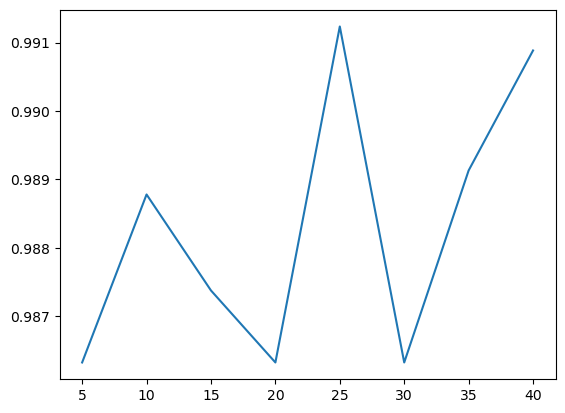

In [192]:
test_accs = []
window_sizes = [5, 10, 15, 20, 25, 30, 35, 40]
for window_size in window_sizes:
    test_acc = classification(n, "xgboost")
    test_accs.append(test_acc)

plt.plot(window_sizes, test_accs)

In [188]:
def make_datasets(window_size):
    X = val_losses[:, :window_size]  # np.expand_dims(val_losses[:, window_size], axis = 1) #

    X = np.expand_dims(val_losses[:, window_size], axis = 1)
    X = np.concatenate([X, cusum_scores[:,:,:window_size].reshape(cusum_scores.shape[0], -1)], axis = 1)
    X = X.reshape(X.shape[0], -1)
    Y = np.array([1 if i in indexes else 0 for i in range(len(X))])
    X_train,  X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = 42)
    X_train[X_train == np.inf] = 1000
    X_test[X_test == np.inf] = 1000

    balancer = RandomUnderSampler()
    balanced_train_x, balanced_train_y = balancer.fit_resample(X_train, Y_train)
    return balanced_train_x,  X_test, balanced_train_y, Y_test



Type: xgboost
Window size: 40
Train accuracy: 1.0
Test accuracy: 0.9891304347826086
Train confusion matrix:
[[564   0]
 [  0 564]]
Test confusion matrix:
[[2675   29]
 [   2  146]]

Type: xgboost
Window size: 40
Train accuracy: 1.0
Test accuracy: 0.9873772791023843
Train confusion matrix:
[[564   0]
 [  0 564]]
Test confusion matrix:
[[2669   35]
 [   1  147]]

Type: xgboost
Window size: 40
Train accuracy: 1.0
Test accuracy: 0.9887798036465638
Train confusion matrix:
[[564   0]
 [  0 564]]
Test confusion matrix:
[[2673   31]
 [   1  147]]

Type: xgboost
Window size: 40
Train accuracy: 1.0
Test accuracy: 0.9894810659186536
Train confusion matrix:
[[564   0]
 [  0 564]]
Test confusion matrix:
[[2675   29]
 [   1  147]]

Type: xgboost
Window size: 40
Train accuracy: 1.0
Test accuracy: 0.988078541374474
Train confusion matrix:
[[564   0]
 [  0 564]]
Test confusion matrix:
[[2671   33]
 [   1  147]]

Type: xgboost
Window size: 40
Train accuracy: 1.0
Test accuracy: 0.9877279102384292
Train 

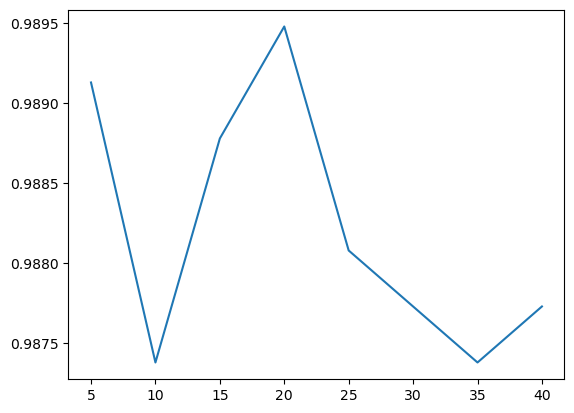

In [190]:
test_accs = []
window_sizes = [5, 10, 15, 20, 25, 30, 35, 40]
for window_size in window_sizes:
    test_acc = classification(n, "xgboost")
    test_accs.append(test_acc)

plt.plot(window_sizes, test_accs)

In [193]:
def make_datasets(window_size):
    X = val_losses[:, :window_size]  # np.expand_dims(val_losses[:, window_size], axis = 1) #

    X = np.expand_dims(val_losses[:, window_size], axis = 1)
    X = np.concatenate([X, cusum_scores[:,:,window_size].reshape(cusum_scores.shape[0], -1)], axis = 1)
    X = X.reshape(X.shape[0], -1)
    Y = np.array([1 if i in indexes else 0 for i in range(len(X))])
    X_train,  X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = 42)
    X_train[X_train == np.inf] = 1000
    X_test[X_test == np.inf] = 1000

    balancer = RandomUnderSampler()
    balanced_train_x, balanced_train_y = balancer.fit_resample(X_train, Y_train)
    return balanced_train_x,  X_test, balanced_train_y, Y_test



Type: xgboost
Window size: 40
Train accuracy: 0.9964539007092199
Test accuracy: 0.988429172510519
Train confusion matrix:
[[564   0]
 [  4 560]]
Test confusion matrix:
[[2672   32]
 [   1  147]]

Type: xgboost
Window size: 40
Train accuracy: 0.9964539007092199
Test accuracy: 0.9908835904628331
Train confusion matrix:
[[564   0]
 [  4 560]]
Test confusion matrix:
[[2679   25]
 [   1  147]]

Type: xgboost
Window size: 40
Train accuracy: 0.9964539007092199
Test accuracy: 0.988078541374474
Train confusion matrix:
[[564   0]
 [  4 560]]
Test confusion matrix:
[[2671   33]
 [   1  147]]

Type: xgboost
Window size: 40
Train accuracy: 0.9964539007092199
Test accuracy: 0.9891304347826086
Train confusion matrix:
[[564   0]
 [  4 560]]
Test confusion matrix:
[[2674   30]
 [   1  147]]

Type: xgboost
Window size: 40
Train accuracy: 0.9964539007092199
Test accuracy: 0.9877279102384292
Train confusion matrix:
[[564   0]
 [  4 560]]
Test confusion matrix:
[[2670   34]
 [   1  147]]

Type: xgboost
Wi

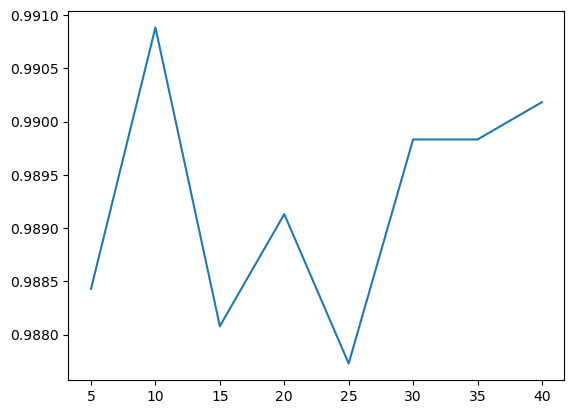

In [195]:
test_accs = []
window_sizes = [5, 10, 15, 20, 25, 30, 35, 40]
for window_size in window_sizes:
    test_acc = classification(n, "xgboost")
    test_accs.append(test_acc)

plt.plot(window_sizes, test_accs)

## Regression 

In [241]:
def make_datasets(window_size):
    X = []
    Y = []
    best_val_losses = []
    for i in tqdm(range(len(search_set))):
        recepie_id = env._logs[i]["recepie_id"]
        log = env._logs[i]["val_losses"]
        if len(log) > window_size:
            if np.isnan(np.min(log)):
                continue
            log_ = log[:window_size] #np.array([log[window_size]]) #
            #emb = df_recepie_vectors.loc[recepie_id].values
            x = log_ #x = np.concatenate((log_, emb)).reshape(-1)
            X.append(x)
            Y.append(np.min(log))
            best_val_losses.append(np.min(log))
    X = np.stack(X)
    Y = np.stack(Y)
    best_val_losses = np.array(best_val_losses)
    indexes = np.argsort(best_val_losses)[:int(len(best_val_losses) * 0.05)]
    assert np.min(best_val_losses[indexes]) == np.min(best_val_losses)
    classes = np.array([1 if i in indexes else 0 for i in range(len(X))])


    X_train,  X_test, Y_train, Y_test, classes_train, classes_test = train_test_split(X, Y, classes, test_size = 0.8, shuffle = True, random_state = 42)
    X_train[X_train == np.inf] = 1000
    X_test[X_test == np.inf] = 1000

    return X_train,  X_test, Y_train, Y_test, classes_train, classes_test
        

In [242]:
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sklearn.metrics import confusion_matrix

In [243]:
def regression(window_size, type = "MLP"):
    print("")
    X_train, X_test, Y_train, Y_test, classes_train, classes_test = make_datasets(window_size)
    if type == "MLP":
        clf = MLPRegressor(max_iter = 1000, random_state = 42).fit(X_train, Y_train)
    elif type == "Forest":
        clf = RandomForestRegressor(random_state = 42).fit(X_train, Y_train)
    elif type == "Gauss":
        clf = GaussianProcessRegressor(random_state = 42).fit(X_train, Y_train)
    elif type == "Neighbors":
        clf = KNeighborsRegressor().fit(X_train, Y_train)
    elif type == "Ada":
        clf = AdaBoostRegressor(random_state = 42).fit(X_train, Y_train)
    elif type == "xgboost":
        clf = XGBRegressor(n_jobs=-1).fit(X_train, Y_train)
        
    print("Type:", type)
    print("Window size:", window_size)
    print("Train loss:", clf.score(X_train, Y_train)) # score returns the coefficient of determination of the prediction.
    print("Test loss:", clf.score(X_test, Y_test))
    pred_y_train = clf.predict(X_train)
    pred_y_test = clf.predict(X_test)

    indexes_train = np.argsort(pred_y_train)[:int(len(pred_y_train) * 0.05)]
    pred_classes_train = np.array([1 if i in indexes_train else 0 for i in range(len(pred_y_train))])

    indexes_test = np.argsort(pred_y_test)[:int(len(pred_y_test) * 0.05)]
    pred_classes_test = np.array([1 if i in indexes_test else 0 for i in range(len(pred_y_test))])
    
    train_acc = np.sum(pred_classes_train == classes_train) / len(classes_train)
    test_acc = np.sum(pred_classes_test == classes_test) / len(classes_test)

    print("Train acc:", train_acc)
    print("Test acc:", test_acc)

    return clf.score(X_test, Y_test), test_acc

100%|██████████| 14322/14322 [00:00<00:00, 80431.92it/s]


Type: xgboost
Window size: 5
Train loss: 0.9988587912575824
Test loss: 0.9235283897554096
Train acc: 0.985351141749246
Test acc: 0.9674709177078845



100%|██████████| 14322/14322 [00:00<00:00, 58609.34it/s]


Type: xgboost
Window size: 10
Train loss: 0.9996078394170105
Test loss: 0.9462925886275054
Train acc: 0.9913793103448276
Test acc: 0.9767266458355781



100%|██████████| 14322/14322 [00:00<00:00, 59000.78it/s]


Type: xgboost
Window size: 15
Train loss: 0.9998111730578577
Test loss: 0.9574033050671917
Train acc: 0.9939655172413793
Test acc: 0.980605538196315



100%|██████████| 14322/14322 [00:00<00:00, 58218.37it/s]


Type: xgboost
Window size: 20
Train loss: 0.9999079200837361
Test loss: 0.9675392504328324
Train acc: 0.9956896551724138
Test acc: 0.9831914664368063



100%|██████████| 14322/14322 [00:00<00:00, 56023.93it/s]


Type: xgboost
Window size: 25
Train loss: 0.9999394289524457
Test loss: 0.9763158329035855
Train acc: 0.9961206896551724
Test acc: 0.9860991379310344



100%|██████████| 14322/14322 [00:00<00:00, 54961.49it/s]


Type: xgboost
Window size: 30
Train loss: 0.9999610974173994
Test loss: 0.9793691003721114
Train acc: 0.9969827586206896
Test acc: 0.9882543103448276



100%|██████████| 14322/14322 [00:00<00:00, 57911.87it/s]


Type: xgboost
Window size: 35
Train loss: 0.9999774792770202
Test loss: 0.9875852876805961
Train acc: 0.9952586206896552
Test acc: 0.9914870689655172



100%|██████████| 14322/14322 [00:00<00:00, 58467.58it/s]


Type: xgboost
Window size: 40
Train loss: 0.9999855154978597
Test loss: 0.9909458320394696
Train acc: 0.9982751185855973
Test acc: 0.9920258620689655


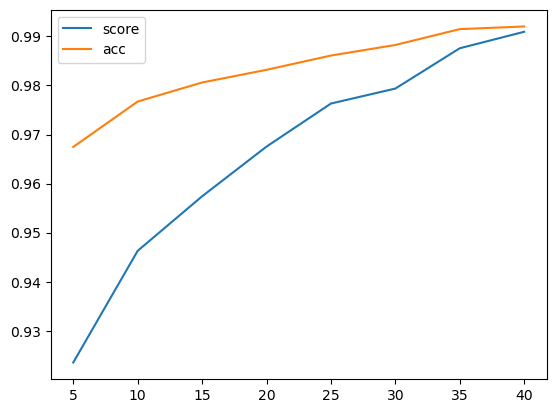

In [244]:
test_scores = []
window_sizes = [5, 10, 15, 20, 25, 30, 35, 40]
for window_size in window_sizes:
    test_loss = regression(window_size, "xgboost")
    test_scores.append(test_loss)

plt.plot(window_sizes, test_scores, label = ["score", "acc"])
plt.legend()

In [235]:
def make_datasets(window_size):
    X = []
    Y = []
    best_val_losses = []
    for i in tqdm(range(len(search_set))):
        recepie_id = env._logs[i]["recepie_id"]
        log = env._logs[i]["val_losses"]
        if len(log) > window_size:
            if np.isnan(np.min(log)):
                continue
            log_ = [log[window_size]] #np.array([log[window_size]]) #
            #emb = df_recepie_vectors.loc[recepie_id].values
            x = log_ #x = np.concatenate((log_, emb)).reshape(-1)
            X.append(x)
            Y.append(np.min(log))
            best_val_losses.append(np.min(log))
    X = np.stack(X)
    Y = np.stack(Y)
    best_val_losses = np.array(best_val_losses)
    indexes = np.argsort(best_val_losses)[:int(len(best_val_losses) * 0.05)]
    assert np.min(best_val_losses[indexes]) == np.min(best_val_losses)
    classes = np.array([1 if i in indexes else 0 for i in range(len(X))])


    X_train,  X_test, Y_train, Y_test, classes_train, classes_test = train_test_split(X, Y, classes, test_size = 0.8, shuffle = True, random_state = 42)
    X_train[X_train == np.inf] = 1000
    X_test[X_test == np.inf] = 1000

    return X_train,  X_test, Y_train, Y_test, classes_train, classes_test
        

100%|██████████| 14322/14322 [00:00<00:00, 76480.08it/s]


Type: xgboost
Window size: 5
Train loss: 0.9853618343260625
Test loss: 0.8579419223108178
Train acc: 0.96122361051271
Test acc: 0.9618698836708316



100%|██████████| 14322/14322 [00:00<00:00, 59955.89it/s]


Type: xgboost
Window size: 10
Train loss: 0.9918580550544016
Test loss: 0.8975841733544252
Train acc: 0.9775862068965517
Test acc: 0.9711238013145135



100%|██████████| 14322/14322 [00:00<00:00, 57505.67it/s]


Type: xgboost
Window size: 15
Train loss: 0.9963370903805981
Test loss: 0.9133553563850743
Train acc: 0.978448275862069
Test acc: 0.9799590561361923



100%|██████████| 14322/14322 [00:00<00:00, 51450.85it/s]


Type: xgboost
Window size: 20
Train loss: 0.9976255356372347
Test loss: 0.9249008897062965
Train acc: 0.9844827586206897
Test acc: 0.9831914664368063



100%|██████████| 14322/14322 [00:00<00:00, 54966.97it/s]


Type: xgboost
Window size: 25
Train loss: 0.9986948190236651
Test loss: 0.9572672011853968
Train acc: 0.9900862068965517
Test acc: 0.983728448275862



100%|██████████| 14322/14322 [00:00<00:00, 58339.14it/s]


Type: xgboost
Window size: 30
Train loss: 0.9994260900477132
Test loss: 0.9656239091953619
Train acc: 0.9943965517241379
Test acc: 0.9882543103448276



100%|██████████| 14322/14322 [00:00<00:00, 55288.73it/s]


Type: xgboost
Window size: 35
Train loss: 0.999697782786526
Test loss: 0.9818662662932444
Train acc: 0.9943965517241379
Test acc: 0.9923491379310345



100%|██████████| 14322/14322 [00:00<00:00, 58207.77it/s]


Type: xgboost
Window size: 40
Train loss: 0.999856955318316
Test loss: 0.9804929859073797
Train acc: 0.9913755929279862
Test acc: 0.9933189655172414


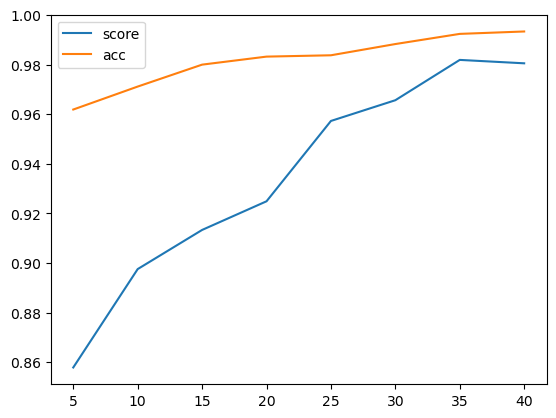

In [238]:
test_scores = []
window_sizes = [5, 10, 15, 20, 25, 30, 35, 40]
for window_size in window_sizes:
    test_loss = regression(window_size, "xgboost")
    test_scores.append(test_loss)

plt.plot(window_sizes, test_scores, label = ["score", "acc"])
plt.legend()

In [245]:
X_train,  X_test, Y_train, Y_test, classes_train, classes_test =  make_datasets(10)

100%|██████████| 14322/14322 [00:00<00:00, 81787.32it/s]


In [286]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(random_seed=42, iterations=1000, learning_rate=0.01, 
                                  loss_function='RMSEWithUncertainty', posterior_sampling=True,
                                  verbose=False)
model.fit(X_train, Y_train, eval_set=(X_test, Y_test), plot = True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [287]:
preds = model.predict(X_test)

(array([ 11.,  22.,  91., 344., 317., 297., 324., 517., 500., 396., 494.,
        547., 564., 439., 285., 253., 212., 222., 229., 280., 180., 224.,
        270., 141., 161., 114.,  84.,  35.,  40.,  24.,  11.,  12.,   7.,
         12.,   3.,   3.,   6.,   8.,   5.,   4.,   2.,   3.,   5.,   3.,
          1.,   0.,   0.,   4.,   0.,   3.,   1.,   5.,  12.,   5.,  34.,
         65.,  39.,  34.,  36.,  39.,  34.,  35.,  31.,  28.,  30.,  33.,
         41.,  60.,  59.,  86., 107., 168.,  93.,  39.,  38.,  53.,  49.,
         85.,  32., 116.,  43.,  14.,  10.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         16.]),
 array([4.61072396, 4.63473525, 4.65874655, 4.68275785, 4.70676914,
        4.73078044, 4.75479174, 4.77880303, 4.80281433, 4.82682563,
        4.85083692, 4.87484822, 4.89885952, 4.92287082, 4.94688211,
        4.97089341, 4.99490471, 5.018916  , 5.0429273 , 5.0669386 ,
        5.09094989, 5.11496119, 5.13897249, 5.

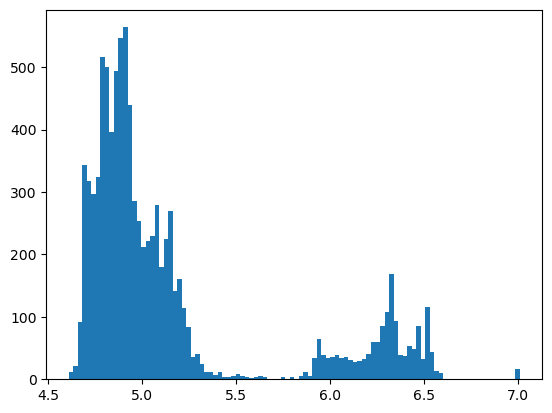

In [288]:
plt.hist(preds[:, 0], bins = 100)

(array([7.675e+03, 4.100e+02, 1.460e+02, 1.410e+02, 1.070e+02, 9.500e+01,
        5.600e+01, 4.900e+01, 6.000e+01, 3.400e+01, 1.400e+01, 2.200e+01,
        2.800e+01, 1.100e+01, 2.000e+01, 1.600e+01, 1.300e+01, 1.100e+01,
        2.400e+01, 2.200e+01, 8.000e+00, 1.100e+01, 1.200e+01, 2.000e+01,
        1.000e+01, 1.000e+01, 1.000e+01, 1.000e+01, 6.000e+00, 9.000e+00,
        1.400e+01, 1.500e+01, 1.100e+01, 1.800e+01, 1.900e+01, 2.000e+01,
        1.800e+01, 2.500e+01, 2.100e+01, 3.200e+01, 1.200e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

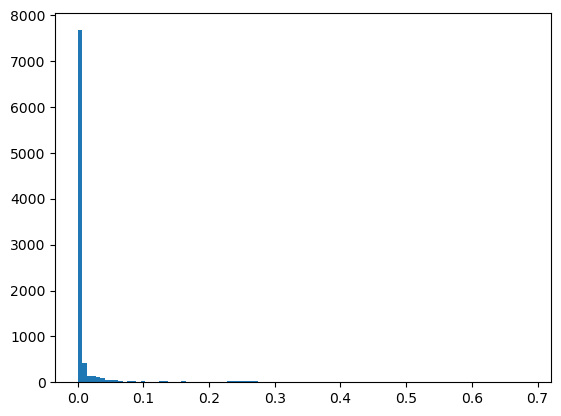

In [289]:
plt.hist(preds[:, 1], bins = 100)

In [290]:
indexes_with_cetrainty = np.argsort(preds[:, 1])[:200]

(array([ 14.,  38.,  10.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  27.,
        108.]),
 array([4.72223713, 4.74041335, 4.75858957, 4.77676578, 4.794942  ,
        4.81311821, 4.83129443, 4.84947065, 4.86764686, 4.88582308,
        4.9039993 , 4.92217551, 4.94035173, 4.95852794, 4.97670416,
        4.99488038, 5.01305659, 5.03123281, 5.04940902, 5.06758524,
        5.08576146, 5.10393767, 5.12211389, 5.

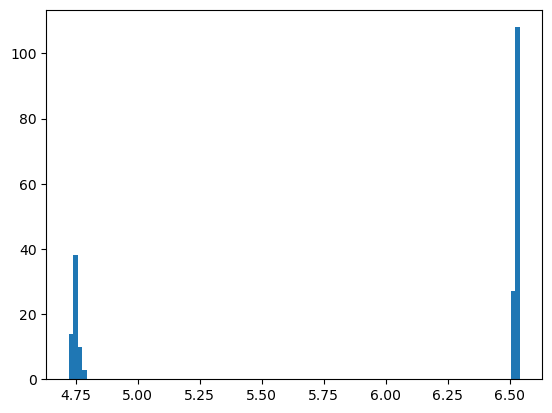

In [291]:
plt.hist(preds[:, 0][indexes_with_cetrainty], bins = 100)

(array([ 6.,  3.,  5.,  2.,  7.,  4., 10.,  7.,  4., 11.,  5.,  2.,  7.,
         3.,  4.,  5.,  1.,  1.,  2.,  1.,  3.,  3.,  1.,  3.,  1.,  1.,
         4.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  3.,  1.,  1.,  3.,  1.,
         0.,  2.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  2.,  2.,  0.,  1.,
         2.,  5.,  5.,  5.,  6.,  8., 10.,  9., 11.]),
 array([5.35360636e-05, 5.62366735e-05, 5.89372835e-05, 6.16378934e-05,
        6.43385034e-05, 6.70391133e-05, 6.97397233e-05, 7.24403332e-05,
        7.51409432e-05, 7.78415531e-05, 8.05421631e-05, 8.32427730e-05,
        8.59433830e-05, 8.86439930e-05, 9.13446029e-05, 9.40452129e-05,
        9.67458228e-05, 9.94464328e-05, 1.02147043e-04, 1.04847653e-04,
        1.07548263e-04, 1.10248873e-04, 1.12949483e-04, 1.15650092e-04,
  

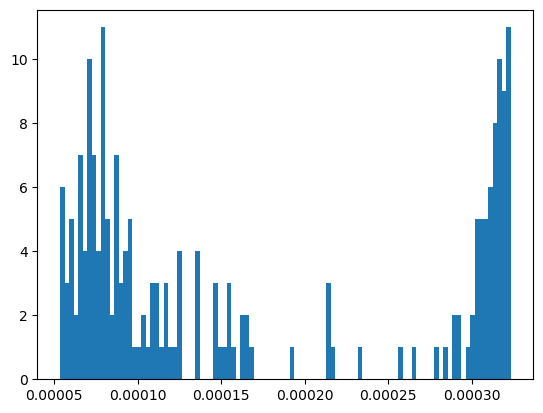

In [292]:
plt.hist(preds[:, 1][indexes_with_cetrainty], bins = 100)

In [293]:
model.score(X_test, Y_test)

0.9328426861213669

100%|██████████| 14322/14322 [00:00<00:00, 84644.11it/s]


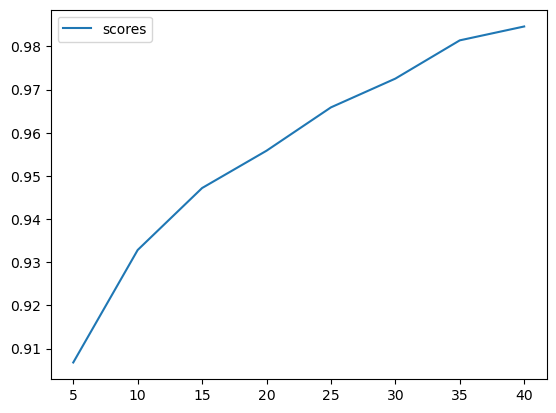

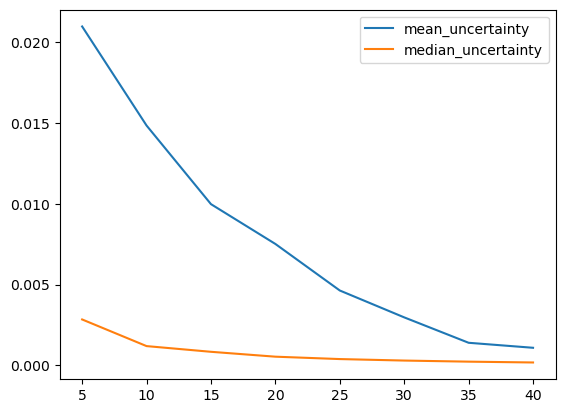

In [295]:
window_sizes = [5, 10, 15, 20, 25, 30, 35, 40]
mean_uncertainty = []
median_uncertainty = []
scores = []

for n in window_sizes:
    X_train,  X_test, Y_train, Y_test, classes_train, classes_test =  make_datasets(n)
    model = CatBoostRegressor(random_seed=42, iterations=1000, learning_rate=0.01, 
                                  loss_function='RMSEWithUncertainty', posterior_sampling=True,
                                  verbose=False)
    model.fit(X_train, Y_train)
    scores.append(model.score(X_test, Y_test))
    mean_uncertainty.append(np.mean(model.predict(X_test)[:, 1]))
    median_uncertainty.append(np.median(model.predict(X_test)[:, 1]))

plt.plot(window_sizes, scores, label = "scores")
plt.legend()
plt.show()
plt.plot(window_sizes, mean_uncertainty, label = "mean_uncertainty")
plt.plot(window_sizes, median_uncertainty, label = "median_uncertainty")
plt.legend()
plt.show()